# Use OSMnx to calculate street network indicators

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import matplotlib.cm as cm
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.13.0'

## Calculate basic street network measures (topological and metric)

In [2]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.basic_stats(ox.graph_from_place('Piedmont, California, USA'))
stats['circuity_avg']

1.0900093971389724

To calculate density-based metrics, you must also pass the network's bounding area in square meters (otherwise basic_stats() will just skip them in the calculation):

In [3]:
# get the street network for a place, and its area in square meters
place = 'Piedmont, California, USA'
gdf = ox.gdf_from_place(place)
area = ox.projection.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type='drive_service')

In [4]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

n                                                                                    413
m                                                                                   1076
k_avg                                                                            5.21065
intersection_count                                                                   350
streets_per_node_avg                                                             2.82809
streets_per_node_counts                   {0: 0, 1: 63, 2: 2, 3: 296, 4: 48, 5: 3, 6: 1}
streets_per_node_proportion            {0: 0.0, 1: 0.15254237288135594, 2: 0.00484261...
edge_length_total                                                                 119599
edge_length_avg                                                                  111.151
street_length_total                                                              62437.9
street_length_avg                                                                  111.1
street_segments_count

Streets/intersection counts and proportions are nested dicts inside the stats dict. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [5]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats['streets_per_node_counts'].items():
    stats['int_{}_count'.format(k)] = count
for k, proportion in stats['streets_per_node_proportion'].items():
    stats['int_{}_prop'.format(k)] = proportion

# delete the no longer needed dict elements
del stats['streets_per_node_counts']
del stats['streets_per_node_proportion']

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name='value'))

,value
n,413.000000
m,1076.000000
k_avg,5.210654
intersection_count,350.000000
streets_per_node_avg,2.828087
edge_length_total,119598.926000
edge_length_avg,111.151418
street_length_total,62437.929000
street_length_avg,111.099518
street_segments_count,562.000000


### Inspect betweenness centrality

In [6]:
G_projected = ox.project_graph(G)
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(53124805, 0.31350246852337416)

In the city of Piedmont, California, the node with the highest betweenness centrality has ~30% of all shortest paths running through it. Let's highlight it in the plot:

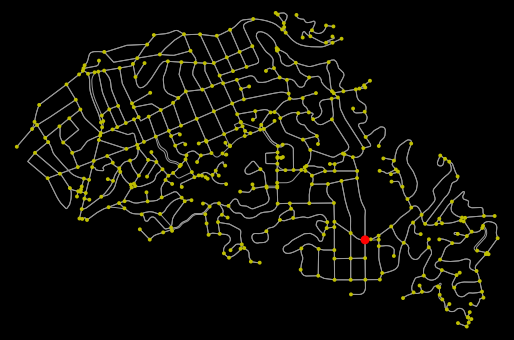

In [7]:
nc = ['r' if node==max_node else 'y' for node in G_projected.nodes()]
ns = [80 if node==max_node else 15 for node in G_projected.nodes()]
fig, ax = ox.plot_graph(G_projected, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k')

~30% of all shortest paths run through the node highlighted in red. Let's look at the relative betweenness centrality of every node in the graph:

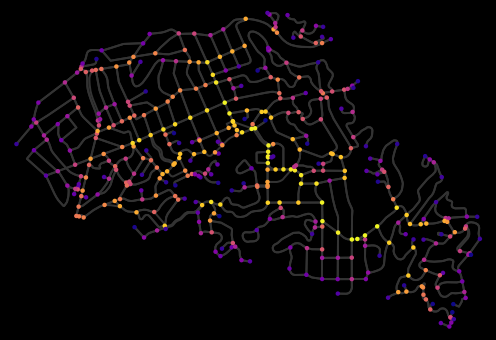

In [8]:
# get a color for each node
def get_color_list(n, color_map='plasma', start=0, end=1):
    return [cm.get_cmap(color_map)(x) for x in np.linspace(start, end, n)]

def get_node_colors_by_stat(G, data, start=0, end=1):
    df = pd.DataFrame(data=pd.Series(data).sort_values(), columns=['value'])
    df['colors'] = get_color_list(len(df), start=start, end=end)
    df = df.reindex(G.nodes())
    return df['colors'].tolist()

nc = get_node_colors_by_stat(G_projected, data=extended_stats['betweenness_centrality'])
fig, ax = ox.plot_graph(G, fig_height=6, node_color=nc, node_size=20, node_zorder=2,
                        edge_linewidth=2, edge_color='#333333', bgcolor='k')

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow).